Import Package and Data

In [159]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")




import os
os.listdir('E:\Data_and_Script\Titanic Data')

['test.csv', 'train.csv']

In [131]:
train = pd.read_csv(r"E:\Data_and_Script\Titanic Data\train.csv")
test = pd.read_csv(r"E:\Data_and_Script\Titanic Data\test.csv")
print(train.shape,test.shape)

(891, 12) (418, 11)


Data Review

In [116]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [117]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [118]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Data Pre-processing

- Data Merge

In [132]:
df = pd.concat([train,test])
train_index = train.shape[0]
df.shape

(1309, 12)

- Imputation

In [120]:
# missing values
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

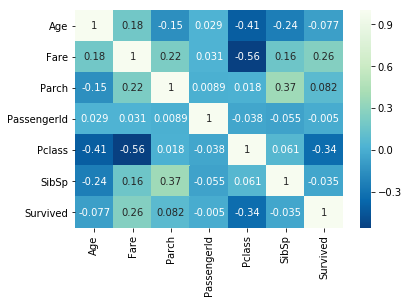

In [17]:
# consider which vairables to fit NAs
sns.heatmap(df.corr(),annot = True,cmap='GnBu_r')
plt.show()

There are 4 variables with missing values, try to impute Age, Embarked and Fare and assign NAs in Cabin with X

In [133]:
mask = ~df.Fare.isnull()
pred_fare = LinearRegression().fit(df.loc[mask,["Parch","Pclass","SibSp"]],df.loc[mask,"Fare"]).predict(df.loc[~mask,["Parch","Pclass","SibSp"]])
df.loc[~mask,"Fare"] = pred_fare

In [134]:
mask = ~df.Embarked.isnull()
pred_embarked = RandomForestClassifier().fit(df.loc[mask,["Fare","Parch","Pclass","SibSp"]],
                                             df.loc[mask,"Embarked"]).predict(df.loc[~mask,["Fare","Parch","Pclass","SibSp"]])
df.loc[~mask,"Embarked"] = pred_embarked

In [135]:
mask = ~df.Age.isnull()
pred_age = RandomForestRegressor().fit(df.loc[mask,["Fare","Parch","Pclass","SibSp"]],
                                        df.loc[mask,"Age"]).predict(df.loc[~mask,["Fare","Parch","Pclass","SibSp"]])
df["New_Age"] = df["Age"]
df.loc[~mask,"New_Age"] = pred_age

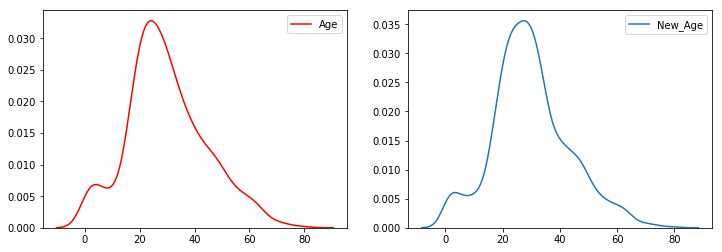

In [136]:
_,ax = plt.subplots(1,2,figsize = (12,4))
sns.kdeplot(df.Age,ax = ax[0],color = "red")
sns.kdeplot(df.New_Age,ax = ax[1])
plt.show() # looks same

In [137]:
df = df.drop("Age",axis = 1)
df.loc[df["Cabin"].isnull(),"Cabin"] = "X"

In [64]:
df.isnull().sum()

Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
New_Age          0
dtype: int64

- Feature Extraction

In [138]:
# Family Name
df["Family_name"] = df.Name.apply(lambda x : x.split(", ")[0])

In [139]:
# Title
df["Title"] = df.Name.apply(lambda x : x.split(", ")[1].split(". ")[0])

In [140]:
df["Cabin_"] = df.Cabin.str[0]

In [191]:
label = df.Survived.astype("category")
df.Survived = df.Survived.astype("object")

EDA
- Parch, Pclass, SibSp seem like cat variables

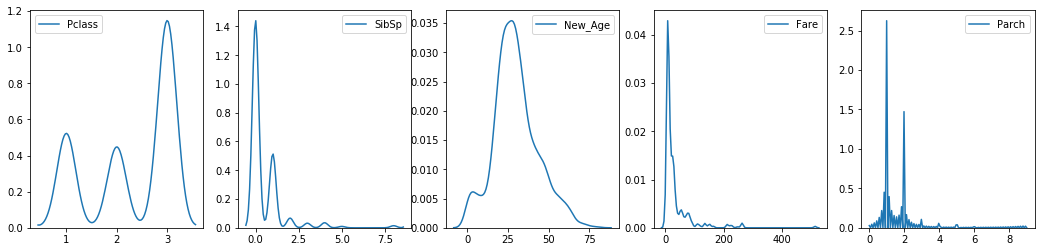

In [69]:
# kdeplot for all numeric variables

f = ["Parch","Pclass","SibSp","New_Age","Fare"]
_,ax = plt.subplots(1,5,figsize = (18,4))
for i,col in enumerate(f) :
    sns.kdeplot(df[col],ax = ax[i-1])
plt.show()    

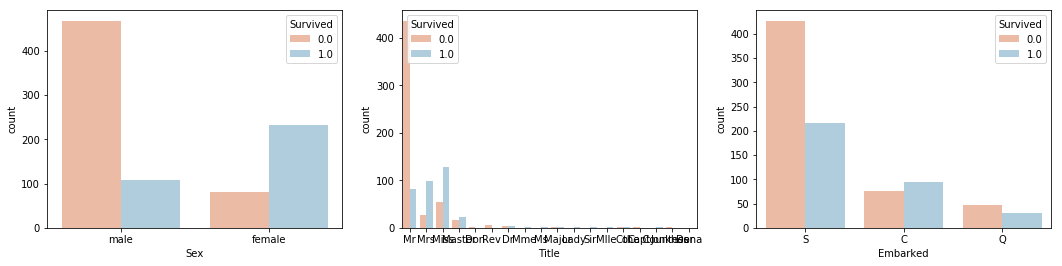

In [70]:
_,ax = plt.subplots(1,3,figsize = (18,4))
for i,col in enumerate(["Embarked","Sex","Title"]):
    sns.countplot(df[col],ax = ax[i-1],palette = "RdBu",hue = label,dodge=True)
plt.show()


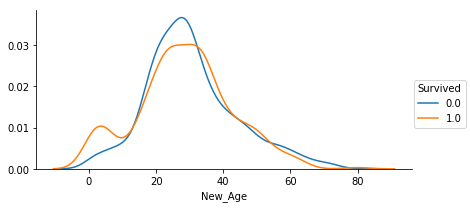

In [71]:
g = sns.FacetGrid(df, hue="Survived",aspect = 2)
g.map(sns.kdeplot,"New_Age")
g.add_legend()
plt.show()

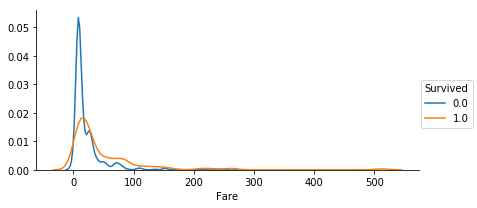

In [72]:
g = sns.FacetGrid(df, hue="Survived",aspect = 2)
g.map(sns.kdeplot,"Fare")
g.add_legend()
plt.show()

Feature Engineering
- Size of group with same ticket number

In [142]:
c = df.groupby("Ticket").size().reset_index(name='counts')
c.columns.values[1] = "Ticket_Size"
df = pd.merge(df,c,on = "Ticket")

- Size of group with same family name

In [143]:
c = df.groupby("Family_name").size().reset_index(name='counts')
c.columns.values[1] = "Family_Name_Size"
df = pd.merge(df,c,on = "Family_name")

- Size of group by Fare

In [144]:
c = df.groupby("Fare").size().reset_index(name='counts')
c.columns.values[1] = "Fare_Size"
df = pd.merge(df,c,on = "Fare")

 - Size of group by Cabin

In [145]:
c = df.groupby("Cabin").size().reset_index(name='counts')
c.columns.values[1] = "Cabin_Size"
df = pd.merge(df,c,on = "Cabin")
df.loc[df.Cabin == "X","Cabin_Size"] = 0

- Age

 - Age to factor variables
 
 Cut Age into different groups, by age = 16,32,60

In [146]:
df["Age_Group"] = 0
df.loc[df["New_Age"] < 16,"Age_Group"] = 1
df.loc[(df["New_Age"] >= 16)&(df["New_Age"] < 32),"Age_Group"] = 2
df.loc[(df["New_Age"] >= 32)&(df["New_Age"] < 60),"Age_Group"] = 3
df.loc[df["New_Age"] >= 60,"Age_Group"] = 4

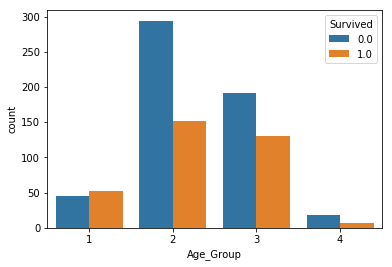

In [147]:
sns.countplot(df.Age_Group,hue = df.Survived)
plt.show()

In [148]:
df["New_Fare"] = RobustScaler().fit_transform(df["Fare"].reshape(-1, 1))

In [149]:
df = df.drop(["Name","Ticket","Family_name","Cabin","New_Age","Fare","Survived"],axis = 1)
df = df.sort_values("PassengerId")
df = df.drop(["PassengerId"],axis = 1)

Baseline model

In [193]:
df_dummy = pd.get_dummies(df,drop_first=True)
x_train,x_test,y_train,y_test = train_test_split(df_dummy.iloc[:train_index,:],label[:train_index],random_state = 1, test_size = 0.25)
cv = StratifiedKFold(10,shuffle=False)

In [274]:
baseline = LogisticRegression(random_state=1)
baseline.fit(x_train,y_train)
pred = baseline.predict(x_test)
print("CV score is {} ".format(cross_val_score(baseline,df_dummy.iloc[:891,:],label[:891],cv = cv).mean()))

CV score is 0.8227181931676315 


Modelling with parameter in hyperopt

- Parameter Tuning

In [ ]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

def gini_xgb(predictions, truth):
    truth = truth.get_label()
    return 'gini', -1.0 * gini(truth, predictions) / gini(truth, truth)

def gini_lgb(truth, predictions):
    score = gini(truth, predictions) / gini(truth, truth)
    return 'gini', score, True

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [1]:
def objective(args):
    
    
    if args["model"] == LogisticRegression :
        
        parameters = {
            'C': args["params"]['C'], 
            'tol': args["params"]['tol']}
        clf = LogisticRegression(random_state=1,n_jobs=4, **parameters)
        
    elif args["model"] == RandomForestClassifier :
        
        parameters = {
            "n_estimators" : int(args["params"]["n_estimators"]),
            "max_depth" :int(args["params"]["max_depth"]),
            "min_samples_split" : int(args["params"]["min_samples_split"])}
        clf = RandomForestClassifier(random_state=1,n_jobs = 4,**parameters)
        
    score = cross_val_score(clf, df_dummy.iloc[:train_index,:],label[:train_index], scoring=gini_scorer, cv=cv).mean()
    print("Gini {:.3f} params {}".format(score, parameters))
    return score

space = hp.choice("classifier",[
    {"model" : LogisticRegression,
     "params" :{
         'C': hp.uniform('C', 0.001,100),
         "tol" : hp.uniform('tol', 0.00001,0.1)}   
     },
    {"model" : RandomForestClassifier,
     "params" :{
         'n_estimators': hp.quniform('n_estimators', 40, 500, 10),
         'max_depth': hp.quniform('max_depth', 3, 10, 1),
         "min_samples_split" : hp.quniform('min_samples_split', 2, 30, 1)
     }
    }
])
    

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=12)
print("-"*40)
print("Hyperopt estimated optimum {}".format(best))

NameError: name 'hp' is not defined

In [268]:
rf_tuned = RandomForestClassifier(random_state=1,max_depth=10,min_samples_split=21,n_estimators=90)
#rf.fit(df.iloc[:891,:],label[:891])
print("Hyper optimization tuned score : {}".format(cross_val_score(rf_tuned,
                                                                   df_dummy.iloc[:891,:],label[:891],cv = cv).mean()))

Hyper optimization tuned score : 0.8384235614572694


- Feature selection

In [ ]:
    def rfecv_plot(clf,train,y,selected_data = False) :

        rfecv = RFECV(clf,cv = cv,step = 1)
        rfecv.fit(train.iloc[:train_index,:],y[:train_index])

        print("Best Score is {} for {} features".format(max(rfecv.grid_scores_),rfecv.n_features_))

        pd.Series(rfecv.grid_scores_).plot(title = "CV Score for different features number")
        plt.show()

        if selected_data == True :
            return train.loc[:,rfecv.support_]

Best Score is 0.8395471569628873 for 31 features


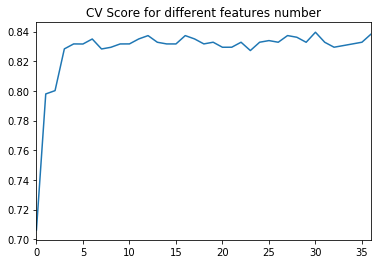

In [285]:
rfecv_plot(rf_tuned,df_dummy,label)

- GBM

In [275]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=1)
#rf.fit(df.iloc[:891,:],label[:891])
print("In sample score : {}".format(cross_val_score(xgb_clf,df_dummy.iloc[:891,:],label[:891],cv = cv).mean()))
xgb_clf.fit(x_train,y_train)
print("Out sample socer : {}".format((xgb_clf.predict(x_test) == y_test).mean()))

In sample score : 0.8328050164567019
Out sample socer : 0.8161434977578476


In [289]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'n_estimators' :int(params["n_estimators"]),
        'learning_rate': '{:.3f}'.format(params["learning_rate"])
    }
    
    clf = xgb.XGBClassifier(radom_state = 1,n_jobs=4,**params)
    
    score = cross_val_score(clf, df_dummy.iloc[:891,:],label[:891], scoring=gini_scorer, cv=cv).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'n_estimators': hp.quniform('n_estimators', 40, 600, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2)
    
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("-"*40)
print("Hyperopt estimated optimum {}".format(best))

Gini -0.769 params {'max_depth': 5, 'gamma': '0.439', 'colsample_bytree': '0.629', 'n_estimators': 534, 'learning_rate': '0.077'}
Gini -0.747 params {'max_depth': 11, 'gamma': '0.254', 'colsample_bytree': '0.853', 'n_estimators': 408, 'learning_rate': '0.101'}
Gini -0.734 params {'max_depth': 14, 'gamma': '0.078', 'colsample_bytree': '0.501', 'n_estimators': 414, 'learning_rate': '0.167'}
Gini -0.731 params {'max_depth': 5, 'gamma': '0.042', 'colsample_bytree': '0.742', 'n_estimators': 547, 'learning_rate': '0.155'}
Gini -0.750 params {'max_depth': 13, 'gamma': '0.248', 'colsample_bytree': '0.912', 'n_estimators': 437, 'learning_rate': '0.079'}
Gini -0.775 params {'max_depth': 5, 'gamma': '0.441', 'colsample_bytree': '0.518', 'n_estimators': 142, 'learning_rate': '0.098'}
Gini -0.759 params {'max_depth': 9, 'gamma': '0.287', 'colsample_bytree': '0.653', 'n_estimators': 118, 'learning_rate': '0.173'}
Gini -0.747 params {'max_depth': 12, 'gamma': '0.007', 'colsample_bytree': '0.387', 'n_

In [290]:
xgb_tuned = xgb.XGBClassifier(radom_state = 1,
                              max_depth=5,
                              colsample_bytree=0.5178656495703302,
                              gamma = 0.4414147353707811,
                              learning_rate = 0.09765428579155672,
                              n_estimators = 142)
print("Hyper optimization tuned score : {}".format(cross_val_score(xgb_tuned,df_dummy.iloc[:891,:],label[:891],cv = cv).mean()))
xgb_tuned.fit(x_train,y_train)
print("Out sample socer : {}".format((xgb_tuned.predict(x_test) == y_test).mean()))

Hyper optimization tuned score : 0.8271623538758369
Out sample socer : 0.8071748878923767


Best Score is 0.8349897854954035 for 20 features


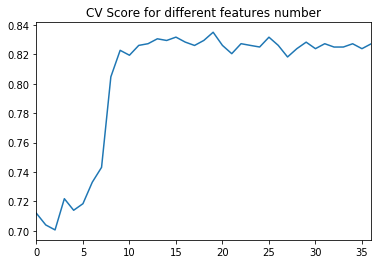

In [291]:
rfecv_plot(xgb_tuned,df_dummy,label)